In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
%matplotlib inline
import pandas as pd
path= ('/content/drive/MyDrive/Colab Notebooks/GenAI/loan_data_nov2023.csv')
#loan_data = pd.read_csv(path)
loan_data = pd.read_csv(path).drop('default', axis=1)
loan_data.head()

,amount,interest,grade,years,ownership,income,age
0,5000,10.65,B,10.0,RENT,24000.0,33
1,2400,10.99,C,25.0,RENT,12252.0,31
2,10000,13.49,C,13.0,RENT,49200.0,24
3,5000,10.99,A,3.0,RENT,36000.0,39
4,3000,10.99,E,9.0,RENT,48000.0,24


In [37]:
# Checking for missing values
missing_values = loan_data.isnull().sum()

# Summary of data types and unique values for categorical columns
data_types = loan_data.dtypes
unique_values = loan_data.select_dtypes(include=['object']).nunique()

missing_values, data_types, unique_values

(amount       0
 interest     0
 grade        0
 years        0
 ownership    0
 income       0
 age          0
 dtype: int64,
 amount         int64
 interest     float64
 grade         object
 years        float64
 ownership     object
 income       float64
 age            int64
 dtype: object,
 grade        7
 ownership    4
 dtype: int64)

<ipython-input-39-ef2c2afe7020>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = loan_data.corr()


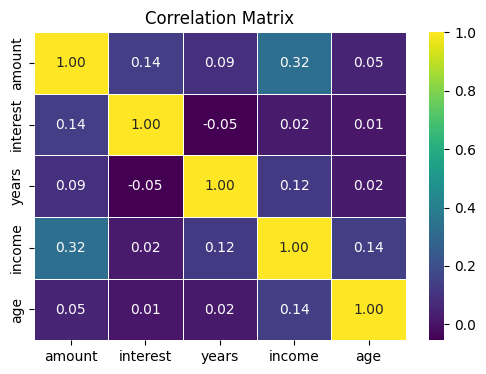

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming loan_data is your DataFrame
# Calculate the correlation matrix
correlation_matrix = loan_data.corr()

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [40]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance
scaler = StandardScaler()

# Identify the numerical columns (excluding categorical ones)
numerical_columns = loan_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = ['grade', 'ownership']  # assuming these are your categorical columns

# Standardizing only the numerical features
loan_data_numerical = loan_data[numerical_columns]
loan_data_numerical_scaled = scaler.fit_transform(loan_data_numerical)

# Convert the scaled array back to a DataFrame
loan_data_numerical_scaled_df = pd.DataFrame(loan_data_numerical_scaled, columns=numerical_columns, index=loan_data.index)

# Combine the scaled numerical features with the categorical features
loan_data_scaled = pd.concat([loan_data_numerical_scaled_df, loan_data[categorical_columns]], axis=1)
loan_data_scaled.head()

,amount,interest,years,income,age,grade,ownership
0,-0.726459,-0.114627,0.593705,-0.806818,0.855900,B,RENT
1,-1.137633,-0.004258,2.868680,-1.027429,0.533033,C,RENT
2,0.064260,0.807277,1.048700,-0.333599,-0.596999,C,RENT
3,-0.726459,-0.004258,-0.467951,-0.581476,1.824499,A,RENT
4,-1.042747,-0.004258,0.442040,-0.356133,-0.596999,E,RENT


#One Hot Encoding with standardized data

In [31]:
from sklearn.preprocessing import OneHotEncoder

# Initializing OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# One-hot encoding the categorical variables
categorical_columns = ['grade', 'ownership']
encoded_data = encoder.fit_transform(loan_data_scaled[categorical_columns])

# Creating a DataFrame with encoded data
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenating the encoded data with the original DataFrame
loan_data_encoded = pd.concat([loan_data_scaled, encoded_df], axis=1)

# Dropping the original categorical columns
loan_data_encoded.drop(categorical_columns, axis=1, inplace=True)

# Display the first few rows of the updated dataset
loan_data_encoded.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,amount,interest,years,income,age,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,ownership_MORTGAGE,ownership_OTHER,ownership_OWN,ownership_RENT
0,-0.726459,-0.114627,0.593705,-0.806818,0.855900,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-1.137633,-0.004258,2.868680,-1.027429,0.533033,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.064260,0.807277,1.048700,-0.333599,-0.596999,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.726459,-0.004258,-0.467951,-0.581476,1.824499,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-1.042747,-0.004258,0.442040,-0.356133,-0.596999,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Defining the features and target variable
X = loan_data_encoded.drop(['amount'], axis=1)
y = loan_data_encoded['amount']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating the linear regression model
model = LinearRegression()

# Training the model
model.fit(X_train, y_train)

# Predicting the loan amounts for the test set
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE: ",mse)
print("R^2: ", r2)

MSE:  0.8495497771082198
R^2:  0.15013091699923098


In [42]:
import numpy as np

# Sample input data for one-hot encoding (Replace these with your values)
# The order of the features is important and should match the training data
sample_input_one_hot = {
    'interest': 10.65,  # Example: interest rate
    'years': 10,  # Example: number of years of employment
    'income': 24000,  # Example: annual income
    'age': 33,  # Example: age of the borrower
    # One-hot encoding for 'grade' (set one to 1 and rest to 0 based on the grade)
    'grade_A': 0,
    'grade_B': 1,
    'grade_C': 0,
    'grade_D': 0,
    'grade_E': 0,
    'grade_F': 0,
    'grade_G': 0,
    # One-hot encoding for 'ownership' (set one to 1 and rest to 0 based on the ownership)
    'ownership_MORTGAGE': 0,
    'ownership_OTHER': 0,
    'ownership_OWN': 0,
    'ownership_RENT': 1
}

# Converting the input data to the format suitable for the model with one-hot encoding
input_data_one_hot = np.array([list(sample_input_one_hot.values())])

# Making a prediction with the one-hot encoded model
predicted_loan_amount_one_hot = model.predict(input_data_one_hot)

# Output the predicted loan amount for one-hot encoded model
predicted_loan_amount_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([6983.97423093])

#One Hot Encoding

In [17]:
from sklearn.preprocessing import OneHotEncoder

# Initializing OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# One-hot encoding the categorical variables
categorical_columns = ['grade', 'ownership']
encoded_data = encoder.fit_transform(loan_data[categorical_columns])

# Creating a DataFrame with encoded data
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenating the encoded data with the original DataFrame
loan_data_encoded = pd.concat([loan_data, encoded_df], axis=1)

# Dropping the original categorical columns
loan_data_encoded.drop(categorical_columns, axis=1, inplace=True)

# Display the first few rows of the updated dataset
loan_data_encoded.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,amount,interest,years,income,age,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,ownership_MORTGAGE,ownership_OTHER,ownership_OWN,ownership_RENT
0,5000,10.65,10.0,24000.0,33,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2400,10.99,25.0,12252.0,31,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,10000,13.49,13.0,49200.0,24,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,5000,10.99,3.0,36000.0,39,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,3000,10.99,9.0,48000.0,24,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Defining the features and target variable
X = loan_data_encoded.drop(['amount'], axis=1)
y = loan_data_encoded['amount']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating the linear regression model
model = LinearRegression()

# Training the model
model.fit(X_train, y_train)

# Predicting the loan amounts for the test set
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE: ",mse)
print("R^2: ", r2)


MSE:  33969134.46255954
R^2:  0.1501309169992303


In [24]:
import numpy as np

# Sample input data for one-hot encoding (Replace these with your values)
# The order of the features is important and should match the training data
sample_input_one_hot = {
    'interest': 10.65,  # Example: interest rate
    'years': 10,  # Example: number of years of employment
    'income': 24000,  # Example: annual income
    'age': 33,  # Example: age of the borrower
    # One-hot encoding for 'grade' (set one to 1 and rest to 0 based on the grade)
    'grade_A': 0,
    'grade_B': 1,
    'grade_C': 0,
    'grade_D': 0,
    'grade_E': 0,
    'grade_F': 0,
    'grade_G': 0,
    # One-hot encoding for 'ownership' (set one to 1 and rest to 0 based on the ownership)
    'ownership_MORTGAGE': 0,
    'ownership_OTHER': 0,
    'ownership_OWN': 0,
    'ownership_RENT': 1
}

# Converting the input data to the format suitable for the model with one-hot encoding
input_data_one_hot = np.array([list(sample_input_one_hot.values())])

# Making a prediction with the one-hot encoded model
predicted_loan_amount_one_hot = model.predict(input_data_one_hot)

# Output the predicted loan amount for one-hot encoded model
predicted_loan_amount_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([8253.41238601])

#Label Encoding

In [4]:
from sklearn.preprocessing import LabelEncoder

# Reloading the dataset and dropping the 'default' column
loan_data = pd.read_csv(path).drop('default', axis=1)

# Creating separate LabelEncoder instances for 'grade' and 'ownership'
label_encoder_grade = LabelEncoder()
label_encoder_ownership = LabelEncoder()

# Applying label encoding to the 'grade' and 'ownership' columns
loan_data['grade_encoded'] = label_encoder_grade.fit_transform(loan_data['grade'])
loan_data['ownership_encoded'] = label_encoder_ownership.fit_transform(loan_data['ownership'])

# Extracting the mappings for 'grade'
grade_mapping = dict(zip(label_encoder_grade.classes_, label_encoder_grade.transform(label_encoder_grade.classes_)))

# Extracting the mappings for 'ownership'
ownership_mapping = dict(zip(label_encoder_ownership.classes_, label_encoder_ownership.transform(label_encoder_ownership.classes_)))

# Display the mappings
print("Grade Mapping:", grade_mapping)
print("Ownership Mapping:", ownership_mapping)

# Displaying the first few rows of the updated DataFrame
loan_data.head()

Grade Mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
Ownership Mapping: {'MORTGAGE': 0, 'OTHER': 1, 'OWN': 2, 'RENT': 3}


,amount,interest,grade,years,ownership,income,age,grade_encoded,ownership_encoded
0,5000,10.65,B,10.0,RENT,24000.0,33,1,3
1,2400,10.99,C,25.0,RENT,12252.0,31,2,3
2,10000,13.49,C,13.0,RENT,49200.0,24,2,3
3,5000,10.99,A,3.0,RENT,36000.0,39,0,3
4,3000,10.99,E,9.0,RENT,48000.0,24,4,3


In [10]:
loan_data.describe()

,amount,interest,years,income,age,grade_encoded,ownership_encoded
count,29091.000000,29091.000000,29091.000000,2.909100e+04,29091.000000,29091.000000,29091.000000
mean,9593.663848,11.003117,6.085422,6.696489e+04,27.698120,1.216149,1.676635
std,6323.467488,3.080636,6.593591,5.325318e+04,6.194617,1.165991,1.433181
min,500.000000,5.420000,0.000000,4.000000e+03,20.000000,0.000000,0.000000
25%,5000.000000,8.490000,2.000000,4.000000e+04,23.000000,0.000000,0.000000
50%,8000.000000,10.990000,4.000000,5.640000e+04,26.000000,1.000000,3.000000
75%,12250.000000,13.110000,8.000000,8.000000e+04,30.000000,2.000000,3.000000
max,35000.000000,23.220000,62.000000,2.039784e+06,94.000000,6.000000,3.000000


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Splitting the dataset into training and testing sets
X = loan_data.drop(['amount','grade','ownership'], axis=1)
y = loan_data['amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating and training the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluating the model
y_pred = model.predict(X_test)
mse_label = mean_squared_error(y_test, y_pred)
r2_label = r2_score(y_test, y_pred)

print("Mean Squared Error: ", mse_label)
print("R-Squared: ", r2_label)

Mean Squared Error:  34351603.590951
R-Squared:  0.14056197470603116


In [14]:
import numpy as np
# Sample input data (Replace these with your values)
# The order of the features is important and should match the training data
sample_input = {
    'interest': 10.65,  # Example: interest rate
    'years': 10,  # Example: number of years of employment
    'income': 24000,  # Example: annual income
    'age': 33,  # Example: age of the borrower
    # Encoded values for 'grade' and 'ownership' (replace with actual encoded values)
    'grade_encoded': 1,  # Replace with the label encoded value for the grade
    'ownership_encoded': 3  # Replace with the label encoded value for the ownership status
}

# Converting the input data to the format suitable for the model
input_data = np.array([list(sample_input.values())])

# Making a prediction
predicted_loan_amount = model.predict(input_data)

# Output the predicted loan amount
print("Predicted Loan Amount is : ", predicted_loan_amount)

Predicted Loan Amount is :  [7704.88794028]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
